In [42]:
#sex_diff
import pandas as pd
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.stats import permutation_test
from matplotlib import cm, colors, colormaps
from matplotlib.patches import Polygon
from nichord.chord import plot_chord
import importlib
import re
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from pycirclize import Circos
import matplotlib
import matplotlib.colors as mcolors
from pycirclize.utils import ColorCycler
from matplotlib.colors import Normalize

In [ ]:
# load data and Yeo networks infomation
def load_data(flavor, outer_folds=100, bins = [8, 11, 14, 18, 22, 29, 36, 45, 55, 65, 80, 101], mul_etiv=False):
    data = scipy.io.loadmat(f'/home/out_log/results_HCPdata_Kraken/newYA95/logistic_regression_ensemble/{flavor}[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]stratifiedCV_split0328_test30newYA_train_downsampledtrain30')
    return data

network_labels = [
    'Visual', 'Somatomotor', 'Dorsal Attention',
    'Ventral Attention', 'Limbic', 'Control',
    'Default', 'Subcortex', 'Cerebellum'
]
bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101] 

group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']
Myeo = scipy.io.loadmat('/home/HCP_data/fc_merged_atlasconcat_justyeo.mat')

## (1) Shen268 FC/SC haufe coefficients heatmap of each region

In [12]:
def heatmap_conn(flavor, atlas, atlas_dim, v_margin, grid_len, bins = bins, mul_etiv=False):
    group_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins) - 1)]
    yeo7 = Myeo['yeo7_index'][atlas][0][0].reshape(-1)         # (268,)
    net_order = [8, 9] + list(range(1, 8))
    reorder_idx = np.hstack([np.where(yeo7 == k)[0] for k in net_order])

    # Keep track of where each network block ends (for grid lines)
    block_sizes = [np.sum(yeo7 == k) for k in net_order]
    block_bounds = np.cumsum(block_sizes)


    # Load + row-wise normalise Haufe coefficients  
    if not mul_etiv:
        result = load_data(flavor)                     
    elif mul_etiv:
        result = load_data(flavor, mul_etiv=True)
    coeff_haufe_beta = {}
    for lbl in group_labels:
        coeff_raw = result[lbl][0][0][1]           # shape: (#ROI, #edges)
        row_max = np.maximum(np.abs(coeff_raw).max(1, keepdims=True), 1e-12)
        coeff_haufe_beta[lbl] = coeff_raw / row_max

    fig, axes = plt.subplots(2, 5, figsize=(17, 6), constrained_layout=True)
    axes = axes.ravel()

    cmap = cm.get_cmap('RdBu_r')                   # diverging red↔blue
    norm = colors.Normalize(vmin=-v_margin, vmax=v_margin)

    for i, lbl in enumerate(group_labels):
        # --- collapse edge list into full symmetric matrix ------------- #
        vec = coeff_haufe_beta[lbl].mean(0)        # ← mean over subjects
        mat = np.zeros((atlas_dim, atlas_dim))
        iu = np.triu_indices(atlas_dim, 1)
        mat[iu] = vec
        mat += mat.T

        # reorder by Yeo 8,9,1-7
        mat = mat[np.ix_(reorder_idx, reorder_idx)]

        # --- plot ------------------------------------------------------ #
        ax = axes[i]
        im = ax.imshow(mat, cmap=cmap, norm=norm, interpolation='nearest')
        ax.set_title(lbl, fontsize=12)
        ax.set_xticks([]), ax.set_yticks([])       # hide ticks

        # ---------------------------  add network name  ---------------------------
        # 1) mid-points of each block after reordering
        tick_pos    = np.cumsum(block_sizes) - np.array(block_sizes)/2 - 0.5
        tick_labels = ['SUB', 'CBL', 'VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'CON', 'DMN']
        # 2) apply to every panel (y-axis only)
        ax.set_yticks(tick_pos)
        ax.set_yticklabels(tick_labels, fontsize=8)            
        ax.tick_params(axis='y', length=0)                    
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(tick_labels, fontsize=8, rotation=90)
        ax.tick_params(axis='x', length=0)
        
        ## grid
        for b in block_bounds[:-1]:
            ax.axhline(b - .5, color='k', lw=grid_len)
            ax.axvline(b - .5, color='k', lw=grid_len)

    # blank any unused axes (if bins < 10)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(
        sm, ax=axes, orientation='vertical', fraction=0.007,  # width of colorbar as fraction of figure width
                    pad=0.02
    )
    cbar.ax.text(0.2, -0.06, 'F', ha='left', va='center', transform=cbar.ax.transAxes)
    cbar.ax.text(0.02, 1.06, 'M', ha='left', va='center', transform=cbar.ax.transAxes)
    plt.show()

/tmp/ipykernel_4136268/3622691747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')                   # diverging red↔blue


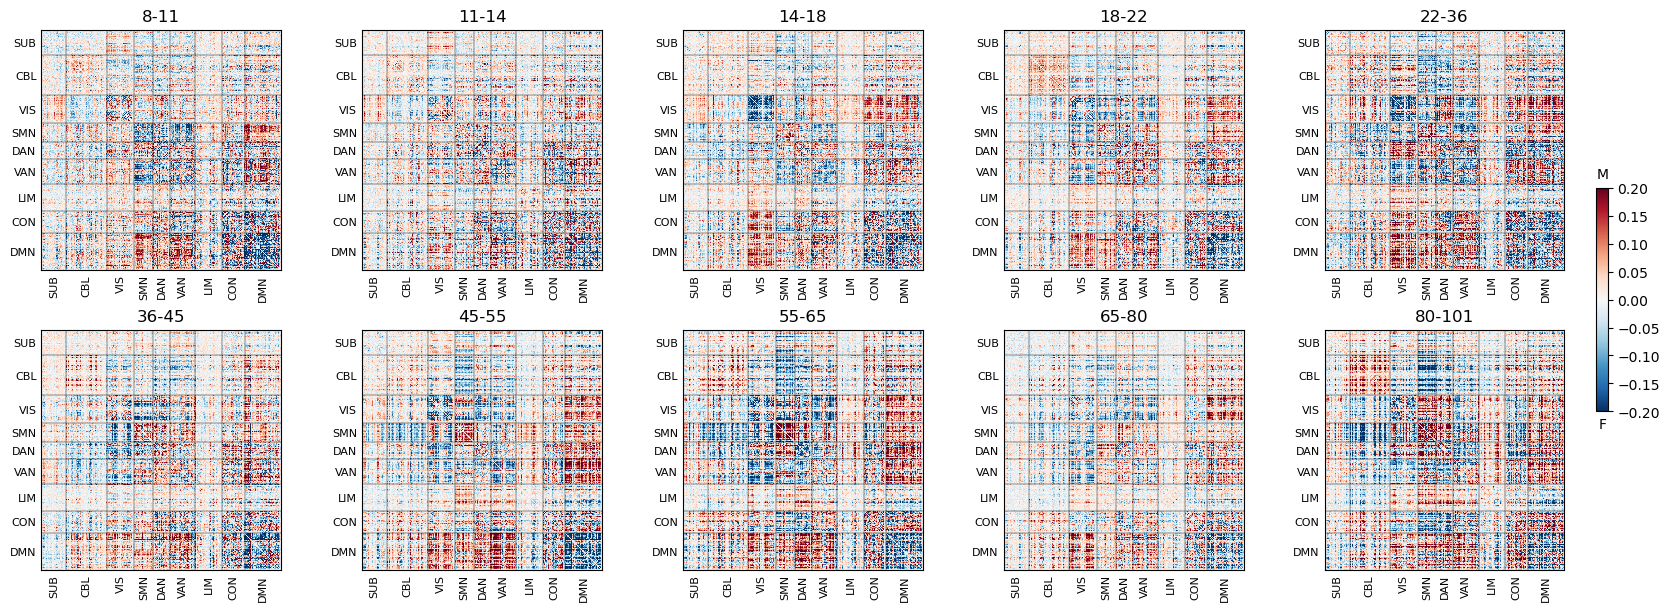

In [13]:
heatmap_conn('FCcorr_shen268_hpfgsr', 'shen268', 268, 0.2, 0.3, bins = bins)

/tmp/ipykernel_4136268/3622691747.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdBu_r')                   # diverging red↔blue


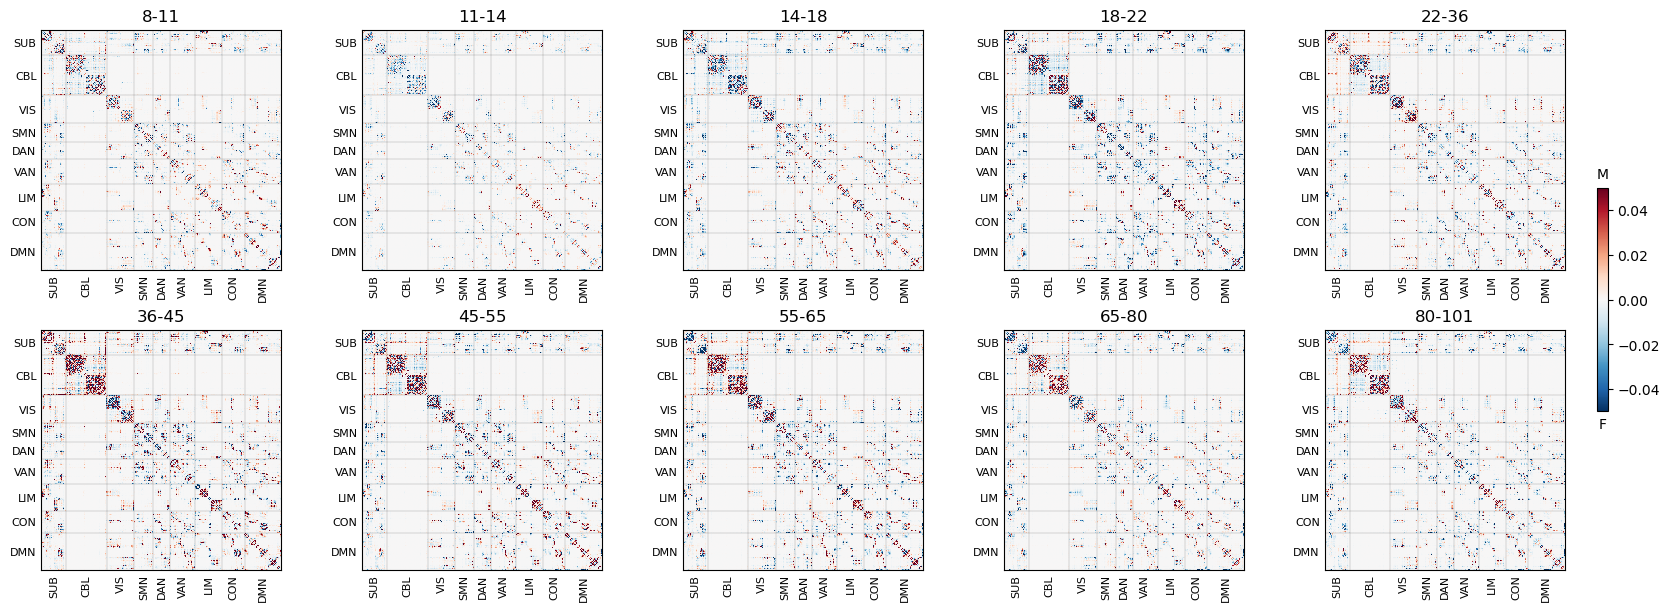

In [14]:
heatmap_conn('SCifod2act_shen268_volnormicv', 'shen268', 268, 0.05, 0.1,bins = bins)

## (2) Barplot and heatmap of network-level age trajectory

In [16]:
def compute_net_importance_for_flavor(flavor, atlas, atlas_dim, bins, Myeo, mul_etiv):
    if not mul_etiv:
        result = load_data(flavor, mul_etiv=False)
    elif mul_etiv:
        result = load_data(flavor, mul_etiv=True)
    n_bins = len(bins) - 1
    coeff_haufe_beta = {}
    for i in range(n_bins):
        coeff_bins = result[f"{bins[i]}-{bins[i+1]}"][0][0][1]
        row_max = np.max(np.abs(coeff_bins), axis=1, keepdims=True)
        coeff_haufe_beta[f"{bins[i]}-{bins[i+1]}"] = coeff_bins / row_max

    yeo7 = Myeo['yeo7_index'][atlas][0][0].reshape(-1,) - 1
    net_importance = {}

    for i in range(n_bins):
        bin_label = f"{bins[i]}-{bins[i+1]}"
        coeff_age = np.mean(np.abs(coeff_haufe_beta[bin_label]), axis=0)
        #coeff_age = np.abs(coeff_age)
        coef_matrix = np.zeros((atlas_dim, atlas_dim))
        upper_indices = np.triu_indices(atlas_dim, k=1)
        coef_matrix[upper_indices] = coeff_age
        coef_matrix += coef_matrix.T

        net_mean = np.zeros(9)
        for net1 in range(9):
            inds1 = np.where(yeo7 == net1)[0]
            vals = coef_matrix[np.ix_(inds1, np.arange(atlas_dim))]
            net_mean[net1] = np.nanmean(vals)
        net_importance[bin_label] = net_mean
    return net_importance


# --- FC flavors ---
flavorsFC = [
    'FCcorr_fs86_hpf', 'FCcorr_fs86_hpfgsr', 'FCpcorr_fs86_hpf',
    'FCcorr_shen268_hpf', 'FCcorr_shen268_hpfgsr', 'FCpcorr_shen268_hpf',
    'FCcorr_coco439_hpf', 'FCcorr_coco439_hpfgsr', 'FCpcorr_coco439_hpf'
]
atlasFC = ['fs86', 'fs86', 'fs86', 'shen268', 'shen268', 'shen268', 'cocommpsuit439', 'cocommpsuit439', 'cocommpsuit439']
atlas_dimFC = [86, 86, 86, 268, 268, 268, 439, 439, 439]

# --- SC flavors ---
flavorsSC = [
    'SCifod2act_fs86_volnormicv', 'SCsdstream_fs86_volnormicv',
    'SCifod2act_shen268_volnormicv', 'SCsdstream_shen268_volnormicv',
    'SCifod2act_coco439_volnormicv', 'SCsdstream_coco439_volnormicv'
]
atlasSC = ['fs86', 'fs86', 'shen268', 'shen268', 'cocommpsuit439', 'cocommpsuit439']
atlas_dimSC = [86, 86, 268, 268, 439, 439]


# --- compute & average across flavors ---
def average_across_flavors(flavors, atlas_list, dim_list, bins, Myeo, mul_etiv):
    all_flavors_importance = []
    for flavor, atlas, atlas_dim in zip(flavors, atlas_list, dim_list):
        net_importance = compute_net_importance_for_flavor(flavor, atlas, atlas_dim, bins, Myeo, mul_etiv)
        all_flavors_importance.append(net_importance)

    n_bins = len(bins) - 1
    avg_net_importance = {}
    for i in range(n_bins):
        bin_label = f"{bins[i]}-{bins[i+1]}"
        stacked = np.stack([imp[bin_label] for imp in all_flavors_importance], axis=0)
        avg_net_importance[bin_label] = np.nanmean(stacked, axis=0)
    return avg_net_importance


# === Compute for FC, SC, and combined ===
avg_net_importance_FC = average_across_flavors(flavorsFC, atlasFC, atlas_dimFC, bins, Myeo, mul_etiv=False)
avg_net_importance_SC = average_across_flavors(flavorsSC, atlasSC, atlas_dimSC, bins, Myeo, mul_etiv=False)

def combine_avg_importance(avg_FC, avg_SC):
    """
    FCs + SCs feature importance by averaging their network means per bin.
    """
    combined = {}
    for bin_label in avg_FC.keys():
        combined[bin_label] = (avg_FC[bin_label] + avg_SC[bin_label]) / 2.0
    return combined

avg_net_importance_FCSC = combine_avg_importance(avg_net_importance_FC, avg_net_importance_SC)

# --- Convert each to DataFrame ---
idx_to_label = {0: 'VIS', 1: 'SMN', 2: 'DAN', 3: 'VAN', 4: 'LIM', 5: 'CON', 6: 'DMN', 7: 'SUB', 8: 'CBL'}

def to_dataframe(avg_net_importance):
    df = pd.DataFrame.from_dict(avg_net_importance, orient='index', columns=[idx_to_label[i] for i in range(9)])
    # reorder SUB, CBL first
    df = df[['SUB', 'CBL', 'VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'CON', 'DMN']]
    return df

df_FC = to_dataframe(avg_net_importance_FC)
df_SC = to_dataframe(avg_net_importance_SC)
df_FCSC = to_dataframe(avg_net_importance_FCSC)

In [ ]:
## bar plot with FDR correction
def barplot_haufe(inc_fusion, inc_fusionFC, inc_fusionSC, *,
    group_labels1, include_ylim, include_bias, exclude_bias,
    alpha=0.05):
    from scipy.stats import spearmanr
    import statsmodels.api as sm
    from patsy import dmatrix
    from statsmodels.stats.multitest import multipletests

    networks = ['Subcortex', 'Cerebellum', 'Visual', 'Somatomotor',
                'Dorsal Attention', 'Ventral Attention',
                'Limbic', 'Control', 'Default']
    networks_short = ['SUB', 'CBL', 'VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'CON', 'DMN']
    n_net      = len(networks)
    bar_width  = 0.11
    intra_gap  = 0.03
    group_gap  = 0.7
    x_centres  = np.arange(n_net) * (1 + group_gap)
    total_w    = len(group_labels1)*bar_width + (len(group_labels1)-1)*intra_gap

    mycolors = ['#000080', '#1F5B94', '#4585B3', '#75ABCA',
                '#5e9a5c', '#9ebf92', '#EDB8B0', '#E69191',
                '#C25759', '#A52A2A', '#800000']

    fig, axes = plt.subplots(3, 1, figsize=(7, 7), gridspec_kw={"hspace": 0.5})

    panel_data = [
        (inc_fusion,  'Fusion', "test_acc_Fusion"),
        (inc_fusionFC,  'Fusion FC', "test_acc_FC"),
        (inc_fusionSC,  'Fusion SC', "test_acc_SC"),
    ]

    for ax, (df_plot, title, metric) in zip(axes.ravel(), panel_data):
        bias = include_bias if title.endswith('Include') else exclude_bias

        # ---- BAR PLOTS ----
        for i, age_bin in enumerate(group_labels1):
            offs = x_centres - total_w/2 + i*(bar_width + intra_gap) + bar_width/2
            ax.bar(
                offs, df_plot.loc[age_bin] + bias,
                width=bar_width,
                label=age_bin if ax is axes[0] else None,
                color=mycolors[i % len(mycolors)]
            )

        # ---- Collect p-values ----
        pvals_spear = np.ones(n_net)
        pvals_quad  = np.ones(n_net)
        for j, net in enumerate(networks):
            yvals = df_plot[networks_short[j]].copy()
            if len(yvals) > 3:
                x = np.arange(len(group_labels1), dtype=float)
                y = yvals.values
                rho, p_spear = spearmanr(x, y)
                X = np.column_stack([x, x**2])
                X = sm.add_constant(X)
                model = sm.OLS(y, X).fit()
                p_quad  = float(model.pvalues[2]) if len(model.pvalues) > 2 else 1.0
                pvals_spear[j] = p_spear
                pvals_quad[j]  = p_quad

        # --- FDR correction across networks ---
        _, pvals_spear_fdr, _, _ = multipletests(pvals_spear, alpha=alpha, method='fdr_bh')
        _, pvals_quad_fdr,  _, _ = multipletests(pvals_quad,  alpha=alpha, method='fdr_bh')

        # ---- Overlay + significance ----
        for j, net in enumerate(networks):
            yvals = df_plot[networks_short[j]].copy()
            if len(yvals) <= 3:
                continue

            sig_mono = (pvals_spear_fdr[j] < alpha)
            sig_quad = (pvals_quad_fdr[j]  < alpha)
            if not (sig_mono or sig_quad):
                continue

            p_value = min(pvals_spear_fdr[j], pvals_quad_fdr[j])
            x = np.arange(len(group_labels1), dtype=float)
            y = yvals.values
            xx = np.linspace(x.min(), x.max(), 100)

            if sig_quad:
                coeffs = np.polyfit(x, y, 2)
                yy = np.polyval(coeffs, xx)
                line_color = "red"
            else:
                coeffs = np.polyfit(x, y, 1)
                yy = np.polyval(coeffs, xx)
                line_color = "green"

            span_start = x_centres[j] - total_w/2 + bar_width/2 + 0.04
            span_end   = x_centres[j] + total_w/2 - bar_width/2 + 0.04
            xx_scaled = span_start + (xx - x.min())/(x.max()-x.min()) * (span_end - span_start)
            y_offset = 0.04 if metric in ['test_acc_FC', 'test_acc_Fusion'] else 0.002
            ax.plot(xx_scaled, yy + y_offset, color=line_color, linewidth=1)

            # --- Add significance star(s) above the line ---
            if p_value < 0.01:
                star_text = '**'
            elif p_value < 0.05:
                star_text = '*'
            else:
                star_text = ''
            if star_text:
                star_y = (yy + y_offset).max()
                ax.text(x_centres[j], star_y, star_text, color='green',
                        ha='center', va='bottom', fontsize=12, fontweight='bold')

        # Cosmetics
        ax.axhline(0, color='black', lw=0.8)
        ax.set_title(title, fontsize=13)
        ax.set_xticks(x_centres)
        ax.set_xticklabels(networks_short, ha='center', fontsize=11)
        ax.margins(x=0.03)
        ax.set_ylabel('Haufe coefficients', fontsize=11)
        if metric == "test_acc_SC":
            ax.set_ylim(0, 0.015)
        else:
            ax.set_ylim(0, 0.2)

    fig.align_ylabels(axes)
    # Legend (age bins)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Age bin', bbox_to_anchor=(1, 0.7), loc='upper center',
               frameon=False, fontsize=9)

    # --- Add annotation for significance marker ---
    y_pos = -0.015  # vertical placement relative to figure
    fig.text(0.4, y_pos, "* / **", color='green', fontsize=11, fontweight='bold', ha='right')
    fig.text(0.41, y_pos, "  Linear association p<0.05/0.01", color='black', fontsize=10, ha='left')
    fig.text(0.01, 0.985, "a)", color='black', fontsize=14, ha='left')
    plt.tight_layout(rect=(0, 0.02, 1, 1))

/tmp/ipykernel_4136268/771142196.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=(0, 0.02, 1, 1))


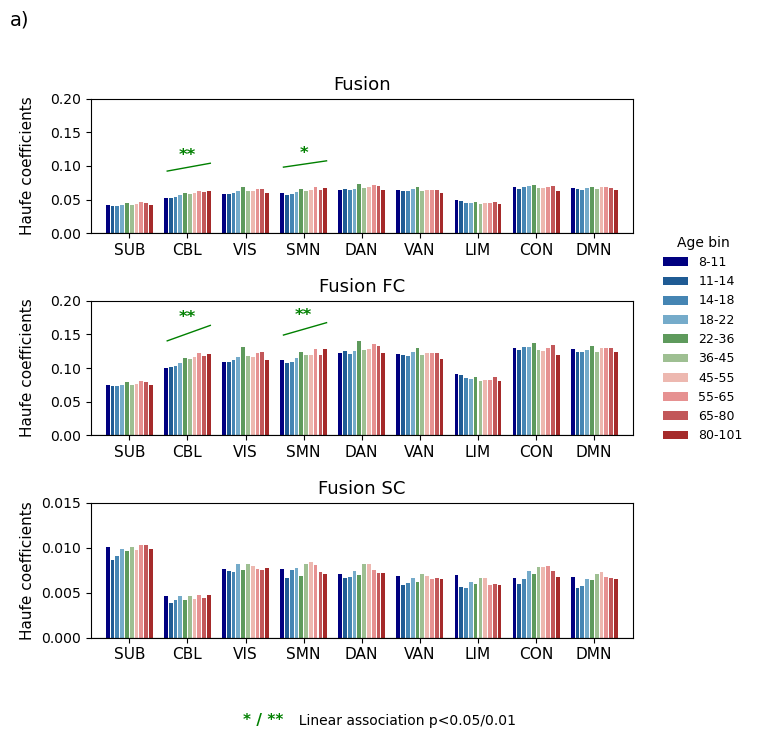

In [ ]:
barplot_haufe(    
    inc_fusion=df_FCSC,
    inc_fusionFC=df_FC,
    inc_fusionSC=df_SC,
    group_labels1=group_labels1,     
    include_ylim=0.2,           
    include_bias=0.0,        
    exclude_bias=0.0,            
    alpha=0.05                 
)

In [23]:
# exact values corresponding to bar plots
def _clean(tick_labels):
    return [re.sub(r'^.*?:\s*', '', lbl.get_text()) for lbl in tick_labels]

def plot_two_heatmaps(acc_fusionFC, acc_fusionSC):
    datasets = [
        ("Fusion FC", acc_fusionFC),
        ("Fusion SC", acc_fusionSC),
    ]

    fig, axes = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'wspace': 0.15})

    for ax, (title, data) in zip(axes, datasets):
        sns.heatmap(
            data,
            annot=True,
            cmap="Blues",
            fmt=".3f",
            cbar=True,            # each plot has its own colorbar
            ax=ax
        )
        ax.set_xlabel("Age", fontsize=11)
        ax.set_title(title, fontsize=13)
        ax.set_yticklabels(_clean(ax.get_yticklabels()), rotation=0)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        # Adjust colorbar label for each subplot
        cbar = ax.collections[0].colorbar
        cbar.set_label("Haufe coefficients", fontsize=11)
        cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4136268/3798577365.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


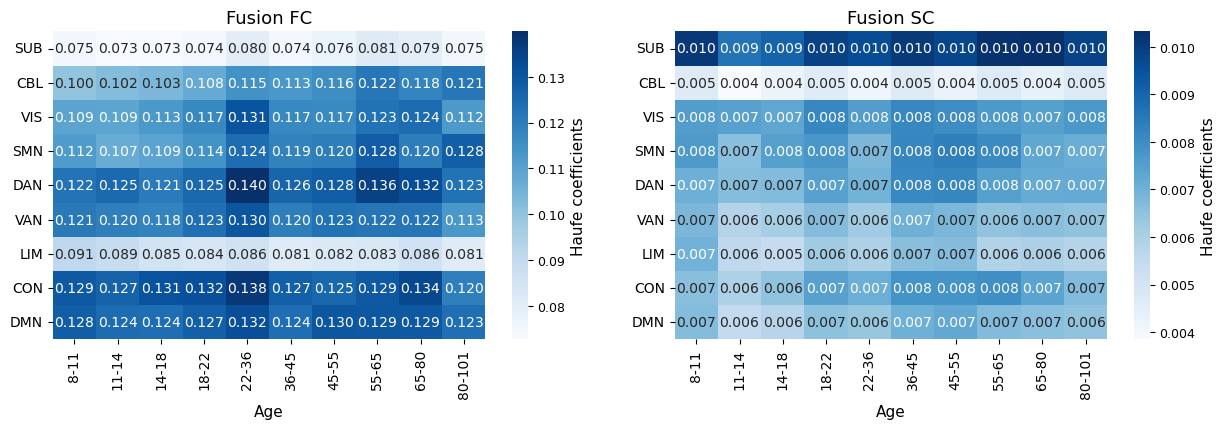

In [24]:
plot_two_heatmaps(df_FC.T, df_SC.T)

## (3) Boxolot and heatmap of Networkpair age trajectory

In [ ]:
# -----------------------------
# Network label definitions
# -----------------------------
idx_to_label = {
    0: 'VIS', 1: 'SMN', 2: 'DAN', 3: 'VAN', 4: 'LIM',
    5: 'CON', 6: 'DMN', 7: 'SUB', 8: 'CBL'
}

# row sorting preference 
pair_order = ['SUB', 'CBL', 'VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'CON', 'DMN']


def _bin_label(bins, i):
    return f"{bins[i]}-{bins[i+1]}"


def _rowwise_norm(coeff_bins):
    """Row-wise normalize by max abs per row (avoid divide-by-zero)."""
    row_max = np.max(np.abs(coeff_bins), axis=1, keepdims=True)
    row_max[row_max == 0] = np.nan
    return coeff_bins / row_max


def _coefvec_to_matrix(coeff_vec, atlas_dim):
    """Upper-tri vector -> full symmetric ROI×ROI matrix (diag=0)."""
    mat = np.zeros((atlas_dim, atlas_dim), dtype=float)
    iu = np.triu_indices(atlas_dim, k=1)
    mat[iu] = coeff_vec
    mat = mat + mat.T
    return mat


def _mean_between_networks(coef_matrix, inds1, inds2, same_net=False):
    """
    Mean edge value between two ROI-sets.
    - If same_net=True: use upper triangle only (no diagonal) to avoid double counting.
    """
    sub = coef_matrix[np.ix_(inds1, inds2)]
    if sub.size == 0:
        return np.nan

    if same_net:
        n = sub.shape[0]
        if n <= 1:
            return np.nan
        triu = np.triu_indices(n, k=1)
        vals = sub[triu]
        return np.nanmean(vals) if vals.size > 0 else np.nan

    return np.nanmean(sub)


def compute_netpair_for_flavor(flavor, atlas, atlas_dim, bins, Myeo, mul_etiv=False):
    """
    Returns:
      netpair_dict[bin_label] = (9,9) matrix of mean abs Haufe per network-pair
    """
    result = load_data(flavor, mul_etiv=mul_etiv)

    n_bins = len(bins) - 1
    yeo7 = Myeo['yeo7_index'][atlas][0][0].reshape(-1,) - 1
    net_inds = [np.where(yeo7 == k)[0] for k in range(9)]

    netpair_dict = {}

    for i in range(n_bins):
        bl = _bin_label(bins, i)

        # coeff_bins is (n_models, n_edges) or similar
        coeff_bins = result[bl][0][0][1]
        coeff_bins = _rowwise_norm(coeff_bins)

        # average across model rows, take abs
        coeff_age = np.nanmean(np.abs(coeff_bins), axis=0)  # (n_edges,)

        coef_matrix = _coefvec_to_matrix(coeff_age, atlas_dim)

        netpair = np.full((9, 9), np.nan, dtype=float)
        for net1 in range(9):
            inds1 = net_inds[net1]
            for net2 in range(net1, 9):
                inds2 = net_inds[net2]
                val = _mean_between_networks(coef_matrix, inds1, inds2, same_net=(net1 == net2))
                netpair[net1, net2] = val
                netpair[net2, net1] = val

        netpair_dict[bl] = netpair

    return netpair_dict


def average_netpair_across_flavors(flavors, atlas_list, dim_list, bins, Myeo, mul_etiv=False):
    """
    For a modality: average net-pair matrices across its flavors.
    Returns:
      avg_netpair[bin_label] = (9,9)
    """
    all_flavor_dicts = []
    for flavor, atlas, atlas_dim in zip(flavors, atlas_list, dim_list):
        all_flavor_dicts.append(
            compute_netpair_for_flavor(flavor, atlas, atlas_dim, bins, Myeo, mul_etiv=mul_etiv)
        )

    n_bins = len(bins) - 1
    avg_netpair = {}

    for i in range(n_bins):
        bl = _bin_label(bins, i)
        mats = np.stack([d[bl] for d in all_flavor_dicts], axis=0)  # (n_flavors, 9, 9)
        avg_netpair[bl] = np.nanmean(mats, axis=0)

    return avg_netpair


def netpair_dict_to_dataframe(netpair_dict, include_symmetric=False, sep="-"):
    """
    Convert netpair_dict[bin_label] = (9,9) into:
      DataFrame index = network pairs (strings), columns = bin_label
    include_symmetric=False -> only i<=j (45 rows incl within-network)
    """
    bin_labels = list(netpair_dict.keys())

    # build row list (pairs)
    pairs = []
    for i in range(9):
        for j in range(9):
            if not include_symmetric and j < i:
                continue
            a = idx_to_label[i]
            b = idx_to_label[j]
            pairs.append((i, j, f"{a}{sep}{b}"))

    # fill columns
    data = {}
    for bl in bin_labels:
        mat = netpair_dict[bl]
        data[bl] = [mat[i, j] for (i, j, _) in pairs]

    df = pd.DataFrame(data, index=[p[2] for p in pairs])

    # sort rows in your preferred network ordering
    def pair_key(pair_str):
        a, b = pair_str.split(sep)
        return (pair_order.index(a), pair_order.index(b))

    df = df.loc[sorted(df.index, key=pair_key)]
    return df


# ============================================================
# DEFINE 3 MODALITIES HERE (FILL THESE IN)
# ============================================================
# Example: each modality may have multiple flavors (e.g., across atlases),
# with matching atlas name and atlas_dim for each flavor.


# --- FC flavors ---
flavorsFusionFC = [
    'FCcorr_fs86_hpf', 'FCcorr_fs86_hpfgsr', 'FCpcorr_fs86_hpf',
    'FCcorr_shen268_hpf', 'FCcorr_shen268_hpfgsr', 'FCpcorr_shen268_hpf',
    'FCcorr_coco439_hpf', 'FCcorr_coco439_hpfgsr', 'FCpcorr_coco439_hpf'
]
atlasFusionFC = ['fs86', 'fs86', 'fs86', 'shen268', 'shen268', 'shen268', 'cocommpsuit439', 'cocommpsuit439', 'cocommpsuit439']
atlas_dimFusionFC = [86, 86, 86, 268, 268, 268, 439, 439, 439]

# --- SC flavors ---
flavorsFusionSC = [
    'SCifod2act_fs86_volnormicv', 'SCsdstream_fs86_volnormicv',
    'SCifod2act_shen268_volnormicv', 'SCsdstream_shen268_volnormicv',
    'SCifod2act_coco439_volnormicv', 'SCsdstream_coco439_volnormicv'
]
atlasFusionSC = ['fs86', 'fs86', 'shen268', 'shen268', 'cocommpsuit439', 'cocommpsuit439']
atlas_dimFusionSC = [86, 86, 268, 268, 439, 439]

# --- all flavors together ---
flavorsFusion = flavorsFusionFC + flavorsFusionSC  
atlasFusion = atlasFusionFC + atlasFusionSC
atlas_dimFusion = atlas_dimFusionFC + atlas_dimFusionSC

# ============================================================
# RUN: compute avg net-pair per modality
# ============================================================
avg_netpair_Fusion = average_netpair_across_flavors(
    flavorsFusion, atlasFusion, atlas_dimFusion, bins, Myeo, mul_etiv=False
)
avg_netpair_FusionFC = average_netpair_across_flavors(
    flavorsFusionFC, atlasFusionFC, atlas_dimFusionFC, bins, Myeo, mul_etiv=False
)
avg_netpair_FusionSC = average_netpair_across_flavors(
    flavorsFusionSC, atlasFusionSC, atlas_dimFusionSC, bins, Myeo, mul_etiv=False
)

df_Fusion   = netpair_dict_to_dataframe(avg_netpair_Fusion,   include_symmetric=False)
df_FusionFC = netpair_dict_to_dataframe(avg_netpair_FusionFC, include_symmetric=False)
df_FusionSC = netpair_dict_to_dataframe(avg_netpair_FusionSC, include_symmetric=False)

print("df_Fusion shape:  ", df_Fusion.shape)
print("df_FusionFC shape:", df_FusionFC.shape)
print("df_FusionSC shape:", df_FusionSC.shape)

df_Fusion shape:   (45, 10)
df_FusionFC shape: (45, 10)
df_FusionSC shape: (45, 10)


In [28]:
###### include_net
df_Fusion = df_Fusion.loc[['SUB-SUB', 'SUB-CBL', 'VIS-SUB', 'SMN-SUB', 'DAN-SUB', 'VAN-SUB', 'LIM-SUB', 'CON-SUB', 'DMN-SUB',
                 'CBL-CBL', 'VIS-CBL', 'SMN-CBL', 'DAN-CBL', 'VAN-CBL', 'LIM-CBL', 'CON-CBL', 'DMN-CBL',
                 'VIS-VIS', 'VIS-SMN', 'VIS-DAN', 'VIS-VAN', 'VIS-LIM', 'VIS-CON', 'VIS-DMN',
                 'SMN-SMN', 'SMN-DAN', 'SMN-VAN', 'SMN-LIM', 'SMN-CON', 'SMN-DMN',
                 'DAN-DAN', 'DAN-VAN', 'DAN-LIM', 'DAN-CON', 'DAN-DMN',
                 'VAN-VAN', 'VAN-LIM', 'VAN-CON', 'VAN-DMN',
                 'LIM-LIM', 'LIM-CON', 'LIM-DMN',
                 'CON-CON', 'CON-DMN',
                 'DMN-DMN'],:]
df_FusionFC = df_FusionFC.loc[['SUB-SUB', 'SUB-CBL', 'VIS-SUB', 'SMN-SUB', 'DAN-SUB', 'VAN-SUB', 'LIM-SUB', 'CON-SUB', 'DMN-SUB',
                 'CBL-CBL', 'VIS-CBL', 'SMN-CBL', 'DAN-CBL', 'VAN-CBL', 'LIM-CBL', 'CON-CBL', 'DMN-CBL',
                 'VIS-VIS', 'VIS-SMN', 'VIS-DAN', 'VIS-VAN', 'VIS-LIM', 'VIS-CON', 'VIS-DMN',
                 'SMN-SMN', 'SMN-DAN', 'SMN-VAN', 'SMN-LIM', 'SMN-CON', 'SMN-DMN',
                 'DAN-DAN', 'DAN-VAN', 'DAN-LIM', 'DAN-CON', 'DAN-DMN',
                 'VAN-VAN', 'VAN-LIM', 'VAN-CON', 'VAN-DMN',
                 'LIM-LIM', 'LIM-CON', 'LIM-DMN',
                 'CON-CON', 'CON-DMN',
                 'DMN-DMN'],:]
df_FusionSC = df_FusionSC.loc[['SUB-SUB', 'SUB-CBL', 'VIS-SUB', 'SMN-SUB', 'DAN-SUB', 'VAN-SUB', 'LIM-SUB', 'CON-SUB', 'DMN-SUB',
                 'CBL-CBL', 'VIS-CBL', 'SMN-CBL', 'DAN-CBL', 'VAN-CBL', 'LIM-CBL', 'CON-CBL', 'DMN-CBL',
                 'VIS-VIS', 'VIS-SMN', 'VIS-DAN', 'VIS-VAN', 'VIS-LIM', 'VIS-CON', 'VIS-DMN',
                 'SMN-SMN', 'SMN-DAN', 'SMN-VAN', 'SMN-LIM', 'SMN-CON', 'SMN-DMN',
                 'DAN-DAN', 'DAN-VAN', 'DAN-LIM', 'DAN-CON', 'DAN-DMN',
                 'VAN-VAN', 'VAN-LIM', 'VAN-CON', 'VAN-DMN',
                 'LIM-LIM', 'LIM-CON', 'LIM-DMN',
                 'CON-CON', 'CON-DMN',
                 'DMN-DMN'],:]

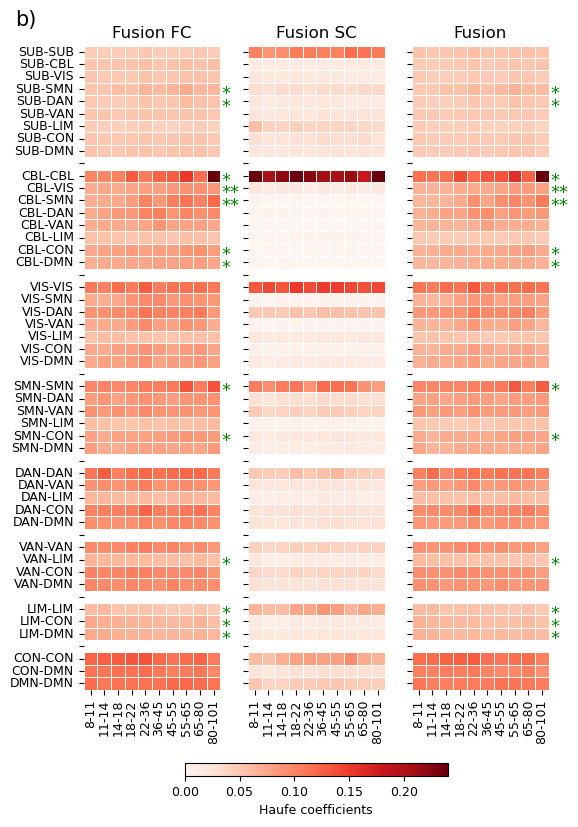

In [30]:
# ---------- Statistical tests ----------
def test_monotonic(y, ages):
    """Spearman rank correlation test."""
    rho, p = spearmanr(ages, y, nan_policy="omit")
    return rho, p

def test_quadratic(y, ages):
    """Quadratic regression: y ~ age + age^2"""
    ages = np.asarray(ages)
    X = np.column_stack([ages, ages**2])
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing="drop").fit()
    # test if quadratic term significant
    p_quad = model.pvalues[2] if len(model.pvalues) > 2 else 1.0
    return p_quad

# ---------- add gaps ----------
def add_gap_rows(df, segments):
    pieces = []
    start = 0
    for seg in segments:
        pieces.append(df.iloc[start:start+seg, :])
        blank = pd.DataFrame(
            np.nan,
            index=[f"gap_{start+seg}"],
            columns=df.columns
        )
        pieces.append(blank)
        start += seg
    pieces.pop()  # drop trailing gap
    return pd.concat(pieces, axis=0)

# ---------- prepared data ----------
segments = [9, 8, 7, 6, 5, 4, 3, 3]
datasets = [
    (df_FusionFC,"Fusion FC"),
    (df_FusionSC,"Fusion SC"),
        (df_Fusion,  "Fusion")
]

age_ranks = np.arange(len(df_Fusion.columns))  # numeric encoding of age bins

# ---------- Run significance tests ----------
sig_dict = {}  # {(modality, netpair): {"mono":pval, "quad":pval}}

for df, title in datasets:
    netpairs = list(df.index)
    p_mono_list = []
    p_quad_list = []

    for netpair, row in df.iterrows():
        y = row.values.astype(float)
        _, p_mono = test_monotonic(y, age_ranks)
        p_quad = test_quadratic(y, age_ranks)
        p_mono_list.append(p_mono)
        p_quad_list.append(p_quad)


    p_mono_list = np.asarray(p_mono_list, dtype=float)
    p_quad_list = np.asarray(p_quad_list, dtype=float)

    # FDR-BH correction within modality (separately for mono and quad)
    _, p_mono_fdr, _, _ = multipletests(p_mono_list, alpha=0.05, method="fdr_bh")
    _, p_quad_fdr, _, _ = multipletests(p_quad_list, alpha=0.05, method="fdr_bh")

    # store
    for netpair, pm, pq, pmf, pqf in zip(netpairs, p_mono_list, p_quad_list, p_mono_fdr, p_quad_fdr):
        sig_dict[(title, netpair)] = {"mono_raw": pm, "quad_raw": pq, "mono_fdr": pmf, "quad_fdr": pqf}

# ---------- Plotting ----------
fig, axes = plt.subplots(1, 3, figsize=(6, 10), sharey=True, sharex=True)

heat_kwargs = dict(
    cmap="Reds",
    mask=None,
    linewidths=0.5,
    linecolor="white",
    xticklabels=True,
    yticklabels=True,
    cbar=False,
    vmin=0,
    #vmax=0.05
)

for ax, (df, title) in zip(axes, datasets):
    combined = add_gap_rows(df, segments)
    heat_kwargs["mask"] = combined.isna()
    im = sns.heatmap(combined, ax=ax, **heat_kwargs)

    # X-ticks (age bins)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

    # Y-tick relabeling
    new_yticks = []
    for lbl in combined.index:
        if lbl.startswith("gap_"):
            new_yticks.append("")
        else:
            left, right = lbl.split("-", 1)
            if right == "SUB":
                new_yticks.append(f"SUB-{left}")
            elif right == "CBL" and left != "SUB":
                new_yticks.append(f"CBL-{left}")
            else:
                new_yticks.append(lbl)
    ax.set_yticklabels(new_yticks, rotation=0)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=9)
    ax.set_title(title, fontsize=12)

    # --- Add stars for significance ---
    for row_idx, netpair in enumerate(combined.index):
        if netpair.startswith("gap_"):
            continue
        key = (title, netpair)
        if key in sig_dict:
            p_mono = sig_dict[key]["mono_fdr"]
            p_quad = sig_dict[key]["quad_fdr"]

            # Monotonic
            if p_mono < 0.01:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "**", va="center", ha="left", fontsize=13, color="green")
            elif p_mono < 0.05:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "*", va="center", ha="left", fontsize=13, color="green")

            # Quadratic
            if p_quad < 0.01:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "**", va="center", ha="left", fontsize=13, color="red")
            elif p_quad < 0.05:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "*",  va="center", ha="left", fontsize=13, color="red")

# ---------- Shared colorbar ----------
fig.subplots_adjust(bottom=0.15)
cbar = fig.colorbar(
    im.collections[0],
    ax=axes,
    orientation="horizontal",
    fraction=0.018,
    pad=0.1
)
cbar.set_label("Haufe coefficients", fontsize=9)
cbar.ax.tick_params(labelsize=9)
fig.text(0.01, 0.9, "b)", color='black', fontsize=15, ha='left')
plt.show()

## Circle plots of the haufe coefficients from a specific age bin.

In [ ]:
def get_hemi_inds(atlas, atlas_dim):
    """
    Returns LH_inds, RH_inds depending on atlas type.
    atlas: string name ("fs86", "shen268", "coco439")
    atlas_dim: integer, number of regions
    """

    if atlas.lower() in ["fs86"]:
        # fs86 (1-based indices → convert to 0-based)
        LH_inds = np.concatenate([
            np.arange(0, 9),    # LH subcort: 1–9
            np.arange(18, 52)   # LH cortex: 19–52
        ])
        RH_inds = np.concatenate([
            np.arange(9, 18),   # RH subcort: 10–18
            np.arange(52, 86)   # RH cortex: 53–86
        ])

    elif atlas.lower() in ["shen268"]:
        LH_inds = np.arange(0, 133)    # 1–133
        RH_inds = np.arange(133, 268)  # 134–268

    elif atlas.lower() in ["cocommpsuit439"]:
        # coco439 numbers only (already derived from the list)
        LH_inds = np.concatenate([
            np.array([
                0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50
            ]),                   # LH subcort: 1,3,5,...,51  (0-based)
            np.array([54,56,58,61,63,66,69,72,75,78]), 
            np.arange(260, 439)   # LH cortex: 261–439
        ])

        RH_inds = np.concatenate([
            np.array([
                1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
            ]),                   # RH subcort: 2,4,6,...,52
            np.array([55,57,60,62,65,68,71,74,77,80]),  # RH cerebellum: 56,58,61,64,66,68,70,72,74,76,78,82
            np.arange(81, 260)    # RH cortex: 82–260
        ])

    else:
        raise ValueError(f"Unknown atlas: {atlas}")

    return LH_inds, RH_inds

def chord_diam_hemi_multi(flavors, atlas_multi, atlas_dim_multi, sex, v_margin, v_margin_base, mul_etiv=False, top_frac=None):
    """
    flavors: list of flavor strings (e.g. 9 FC flavors)
    atlas, atlas_dim: atlas name and dimension
    sex: 'female' or 'male'
    v_margin: scaling margin for line widths & colormap
    """

    # --- collect results for each flavor ---
    all_results_per_flavor = []
    if len(flavors) == 9: # FC
        l_max = 4.5
    elif len(flavors) == 6: # SC
        l_max = 4
    for idx in range(len(flavors)):
        flavor = flavors[idx]
        atlas = atlas_multi[idx]
        atlas_dim = atlas_dim_multi[idx]

        # Load + row-wise normalise Haufe coefficients  
        if not mul_etiv:        
            result = load_data(flavor)
        elif mul_etiv:
            result = load_data(flavor, mul_etiv=True)
        n_bins = len(bins) - 1
        coeff_haufe_beta = {}
        for i in range(n_bins):
            coeff_bins = result[f"{bins[i]}-{bins[i+1]}"][0][0][1]
            row_max = np.max(np.abs(coeff_bins), axis=1, keepdims=True)
            coeff_haufe_beta[f"{bins[i]}-{bins[i+1]}"] = coeff_bins / row_max

        yeo7 = Myeo['yeo7_index'][atlas][0][0].reshape(-1,) - 1
        LH_inds, RH_inds = get_hemi_inds(atlas, atlas_dim)
        all_results = []
        for i in range(n_bins):
            coeff_age = coeff_haufe_beta[group_labels1[i]].mean(axis=0)

            coef_matrix = np.zeros((atlas_dim, atlas_dim))
            upper_indices = np.triu_indices(atlas_dim, k=1)
            coef_matrix[upper_indices] = coeff_age
            coef_matrix += coef_matrix.T

            for net1 in range(9):
                for net2 in range(net1, 9):
                    inds1 = np.where(yeo7 == net1)[0]
                    inds2 = np.where(yeo7 == net2)[0]

                    LH1 = np.intersect1d(inds1, LH_inds)
                    LH2 = np.intersect1d(inds2, LH_inds)
                    sub_LH = coef_matrix[np.ix_(LH1, LH2)]

                    RH1 = np.intersect1d(inds1, RH_inds)
                    RH2 = np.intersect1d(inds2, RH_inds)
                    sub_RH = coef_matrix[np.ix_(RH1, RH2)]

                    sub_LH_RH = coef_matrix[np.ix_(inds1, inds2)][
                        np.isin(inds1, LH_inds)[:, None] &
                        np.isin(inds2, RH_inds)[None, :]
                    ]

                    sub_RH_LH = coef_matrix[np.ix_(inds1, inds2)][
                        np.isin(inds1, RH_inds)[:, None] &
                        np.isin(inds2, LH_inds)[None, :]
                    ]

                    def sex_mean(arr):
                        if arr.size == 0:
                            return np.nan
                        if sex == 'female':
                            return np.nanmean(arr[arr < 0])
                        elif sex == 'male':
                            return np.nanmean(arr[arr > 0])
                        else:
                            return np.nanmean(arr)

                    val_LH = sex_mean(sub_LH)
                    val_RH = sex_mean(sub_RH)
                    val_LHtoRH = sex_mean(sub_LH_RH)
                    val_RHtoLH = sex_mean(sub_RH_LH)

                    all_results.append({
                        "bin": f"{bins[i]}-{bins[i+1]}",
                        "net1": net1,
                        "net2": net2,
                        "LH_mean": val_LH,
                        "RH_mean": val_RH,
                        "LHtoRH_mean": val_LHtoRH,
                        "RHtoLH_mean": val_RHtoLH                        
                    })
        all_results_per_flavor.append(all_results)

    # --- average across flavors ---
    # Structure: for each bin, net1, net2 → average LH, RH, LHRH
    averaged_results = []
    for entries in zip(*all_results_per_flavor):  # tuples across flavors
        bin_label = entries[0]["bin"]
        net1, net2 = entries[0]["net1"], entries[0]["net2"]
        LH_vals = [e["LH_mean"] for e in entries]
        RH_vals = [e["RH_mean"] for e in entries]
        LHtoRH_vals = [e["LHtoRH_mean"] for e in entries]
        RHtoLH_vals = [e["RHtoLH_mean"] for e in entries]

        averaged_results.append({
            "bin": bin_label,
            "net1": net1,
            "net2": net2,
            "LH_mean": np.nanmean(LH_vals),
            "RH_mean": np.nanmean(RH_vals),
            "LHtoRH_mean": np.nanmean(LHtoRH_vals),
            "RHtoLH_mean": np.nanmean(RHtoLH_vals)
        })

    LH_pos_map = {0: 50, 1: 70, 2: 90, 3: 110, 4: 130, 5: 150, 6: 170, 7: 10, 8: 30} # 0: 'VIS', 1: 'SMN', 2: 'DAN', 3: 'VAN', 4: 'LIM', 5: 'CON', 6: 'DMN', 7: 'SUB', 8: 'CBL'
    RH_pos_map = {0: 130, 1: 110, 2: 90, 3: 70, 4: 50, 5: 30, 6: 10, 7: 170, 8: 150}
    def get_pos(net, hemi): return LH_pos_map[net] if hemi == "LH" else RH_pos_map[net]

    age_bins = ['8-11','11-14','14-18','18-22','22-36','36-45','45-55','55-65','65-80','80-101']
    cmap = matplotlib.colormaps["Blues_r"] if sex == "female" else matplotlib.colormaps["Reds"]
    norm = mcolors.Normalize(vmin=-v_margin, vmax=-v_margin_base) if sex == "female" else mcolors.Normalize(vmin=v_margin_base, vmax=v_margin)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    network_labels = ["SUB","CBL","VIS","SMN","DAN","VAN","LIM","CON","DMN"]
    ColorCycler.set_cmap("tab10")
    network_colors = {net: ColorCycler() for net in network_labels}
    sector_colors = {"LH":"white","RH":"white"}

    for ax, bin_name in zip(axes, age_bins):
        bin_list = []
        for entry in averaged_results:
            if entry["bin"] == bin_name:
                net1, net2 = entry["net1"], entry["net2"]
                net1_LHpos, net2_LHpos = get_pos(net1, "LH"), get_pos(net2, "LH")
                net1_RHpos, net2_RHpos = get_pos(net1, "RH"), get_pos(net2, "RH")
                if net1 == net2:
                    bin_list.append((("LH", net1_LHpos-8), ("LH", net2_LHpos+8), entry["LH_mean"]))
                    bin_list.append((("RH", net1_RHpos-8), ("RH", net2_RHpos+8), entry["RH_mean"]))
                    sym_LHRH = np.nanmean([entry["LHtoRH_mean"], entry["RHtoLH_mean"]])
                    bin_list.append((("LH", net1_LHpos), ("RH", net2_RHpos), sym_LHRH))
                else:
                    bin_list.append((("LH", net1_LHpos), ("LH", net2_LHpos), entry["LH_mean"]))
                    bin_list.append((("RH", net1_RHpos), ("RH", net2_RHpos), entry["RH_mean"]))
                    bin_list.append((("LH", net1_LHpos), ("RH", net2_RHpos), entry["LHtoRH_mean"]))
                    bin_list.append((("RH", net1_RHpos), ("LH", net2_LHpos), entry["RHtoLH_mean"]))

        bin_list = [item for item in bin_list if not np.isnan(item[2])]

        if top_frac is not None and len(bin_list) > 0:
            # Compute threshold so we only keep top_frac of |weight|
            abs_weights = np.array([abs(item[2]) for item in bin_list])
            # e.g. top 5% => 95th percentile
            q = 1.0 - top_frac
            # guard in case top_frac is weird
            q = min(max(q, 0.0), 1.0)
            thr = np.quantile(abs_weights, q)
            filtered_bin_list = [item for item in bin_list if abs(item[2]) >= thr]

        else:
            filtered_bin_list = bin_list


        circos = Circos({"RH":180,"LH":180}, space=5, start=5, end=360, endspace=False)
        for sector in circos.sectors:
            outer_track = sector.add_track((90, 100))
            outer_track.text(sector.name, color="black", size=18, weight="bold")
            outer_track.axis(fc=sector_colors[sector.name], ec="none")
            rect_track = sector.add_track((75, 90))
            rect_size = 20
            n_rects = int(rect_track.size / rect_size)
            indices = reversed(range(n_rects)) if sector.name == "RH" else range(n_rects)
            for idx, i in enumerate(indices):
                net = network_labels[idx]
                x1, x2 = i*rect_size, i*rect_size+rect_size
                rect_track.rect(x1, x2, ec="black", lw=0.5, color=network_colors[net])
                rect_track.text(net, (x1+x2)/2, size=15, color="white", weight="bold")

        sorted_bin_list = sorted(filtered_bin_list, key=lambda x: abs(x[2]))
        
        for item in sorted_bin_list:
            weight = item[2]
            if len(flavors) == 9: # FC
                lw = abs(weight) * 30
            elif (len(flavors) == 6) or (len(flavors) == 4): # SC 6; etiv SC (current 4; shen268, fs86)
                lw = abs(weight) * 100
            
            color = cmap(norm(weight))
            circos.link_line(item[0], item[1], r1=90, r2=90, color=color, lw=lw)               

        subfig = circos.plotfig(figsize=(5, 5))
        subfig.canvas.draw()
        ax.imshow(subfig.canvas.buffer_rgba())
        ax.axis("off")
        ax.text(0.5, 0.97, f"Age {bin_name}", fontsize=12, ha="center", va="bottom", transform=ax.transAxes)
        plt.close(subfig)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
    cax.text(0.5, 1.05, "F" if sex=="female" else "M", ha="center", va="bottom", fontsize=14, transform=cax.transAxes)
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    if sex == 'female':
        fig.text(0.1, 0.88, "a)", fontsize=18, ha='right')   
    elif sex == 'male':
        fig.text(0.1, 0.88, "b)", fontsize=18, ha='right')
    plt.show()

/tmp/ipykernel_4136268/3531879468.py:121: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr < 0])


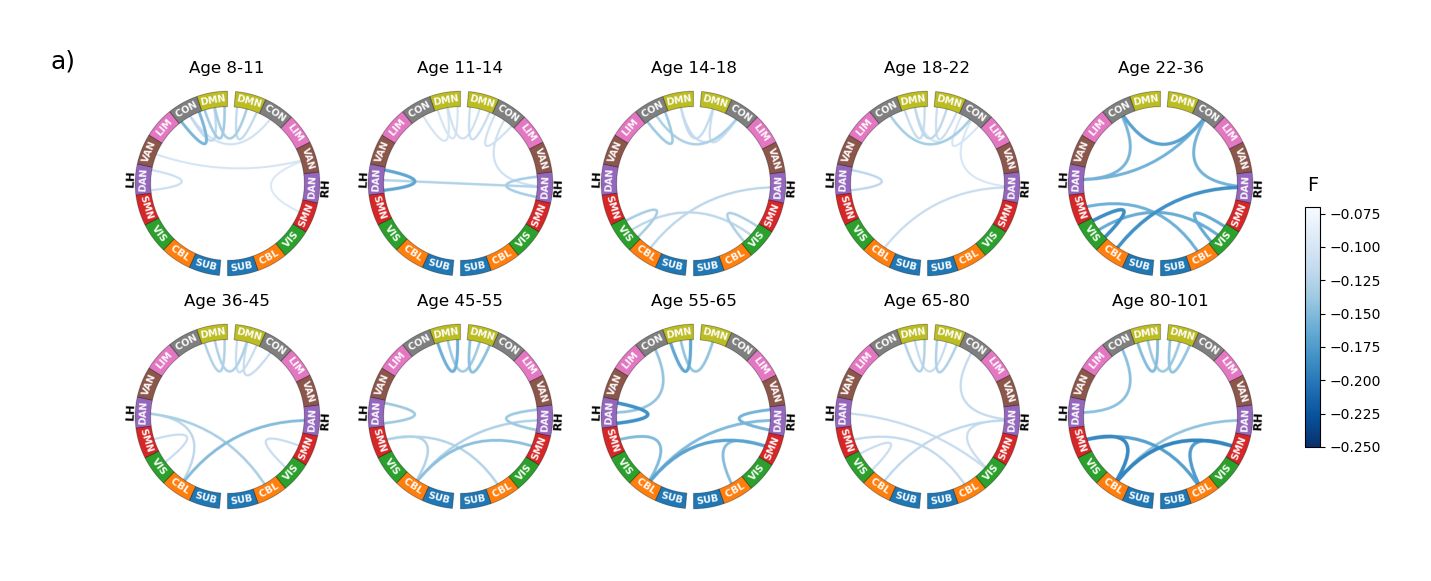

/tmp/ipykernel_4136268/3531879468.py:123: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr > 0])


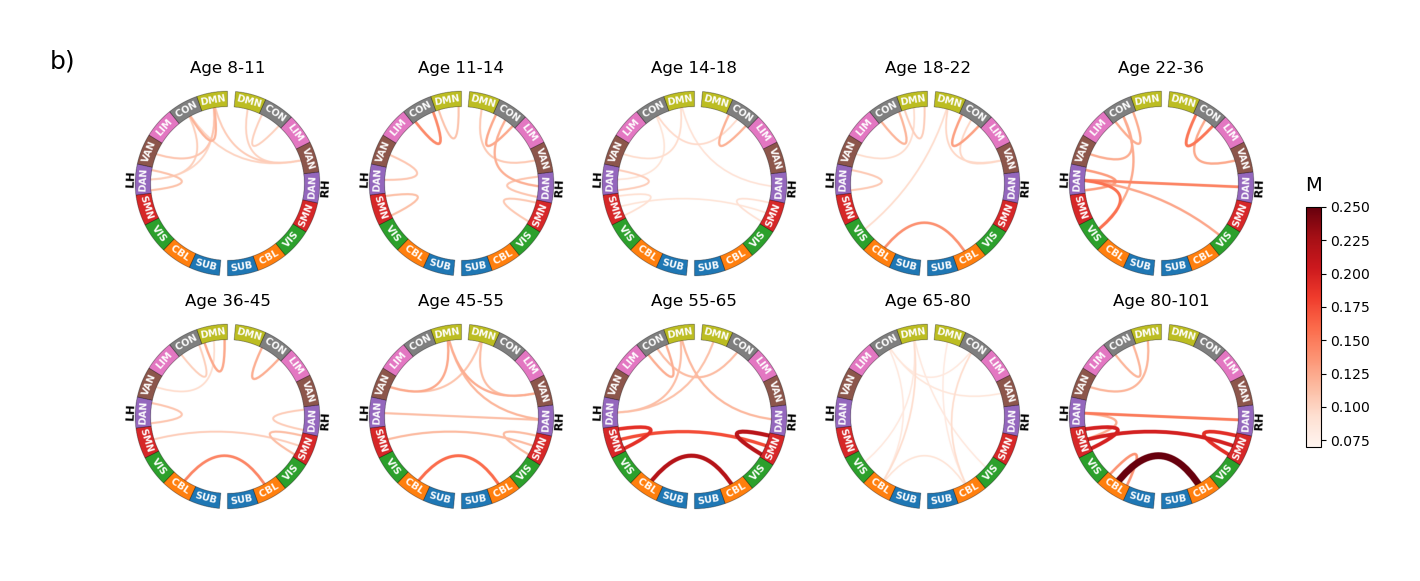

In [34]:
flavorsFC = ['FCcorr_fs86_hpf', 'FCcorr_fs86_hpfgsr', 'FCpcorr_fs86_hpf', 'FCcorr_shen268_hpf', 'FCcorr_shen268_hpfgsr', 'FCpcorr_shen268_hpf', 
           'FCcorr_coco439_hpf', 'FCcorr_coco439_hpfgsr', 'FCpcorr_coco439_hpf']
atlasFC = ['fs86', 'fs86', 'fs86', 'shen268', 'shen268', 'shen268', 'cocommpsuit439', 'cocommpsuit439', 'cocommpsuit439']
atlas_dimFC = [86, 86, 86, 268, 268, 268, 439, 439, 439]
chord_diam_hemi_multi(flavorsFC, atlasFC, atlas_dimFC, 'female', 0.25, 0.07, top_frac = 0.05)
chord_diam_hemi_multi(flavorsFC, atlasFC, atlas_dimFC, 'male', 0.25, 0.07, top_frac = 0.05)

/tmp/ipykernel_4136268/3531879468.py:121: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr < 0])


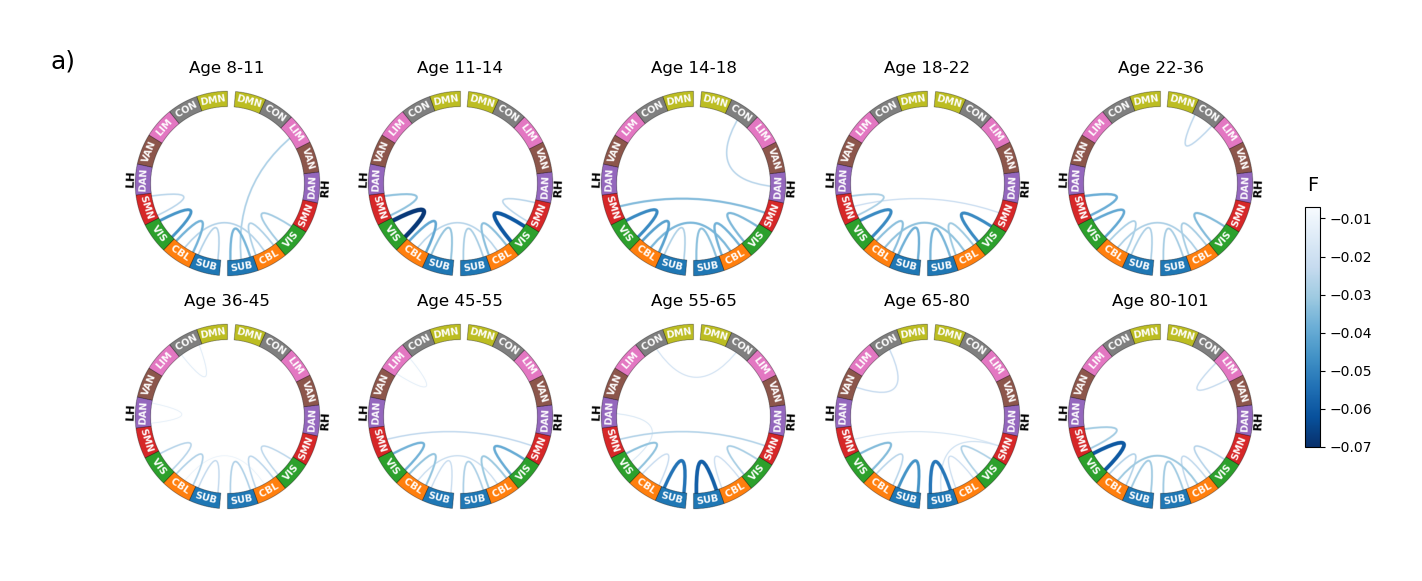

/tmp/ipykernel_4136268/3531879468.py:123: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr > 0])


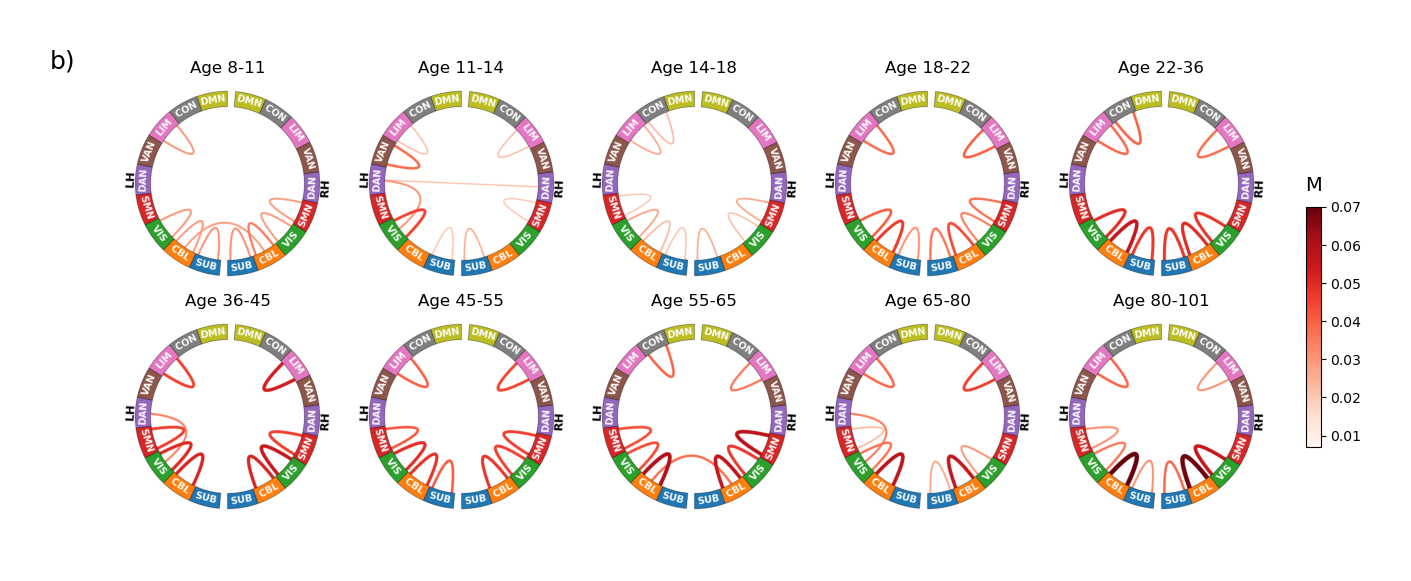

In [35]:
flavorsSC = ['SCifod2act_fs86_volnormicv', 'SCsdstream_fs86_volnormicv', 'SCifod2act_shen268_volnormicv', 'SCsdstream_shen268_volnormicv',
             'SCifod2act_coco439_volnormicv', 'SCsdstream_coco439_volnormicv']
atlasSC = ['fs86', 'fs86', 'shen268', 'shen268', 'cocommpsuit439', 'cocommpsuit439']
atlas_dimSC = [86, 86, 268, 268, 439, 439]
chord_diam_hemi_multi(flavorsSC, atlasSC, atlas_dimSC, 'female', 0.07, 0.007, top_frac = 0.05)
chord_diam_hemi_multi(flavorsSC, atlasSC, atlas_dimSC, 'male', 0.07, 0.007, top_frac = 0.05)

### Directionality of haufe coefficients across ages

In [43]:
def run_trend_tests(flavors, atlas_multi, atlas_dim_multi, sex, bins, group_labels1, Myeo, mul_etiv=False):
    """
    Compute averaged Haufe results across flavors, then run Spearman + quadratic tests.

    Parameters
    ----------
    flavors : list of str
        Flavor names (9 = FC, 6 = SC).
    atlas_multi : list of str
        Corresponding atlas names.
    atlas_dim_multi : list of int
        Atlas dimensions.
    sex : str
        'female' (take negative coeffs), 'male' (take positive coeffs).
    bins : list
        Age bins boundaries.
    group_labels1 : list
        Labels for age bins.
    Myeo : dict
        Mapping of atlas → Yeo7 labels.

    Returns
    -------
    results_tests : pd.DataFrame
        Full test results.
    sig_results : pd.DataFrame
        Only significant results (p < 0.05).
    """

    # collect results from all flavors
    all_results_per_flavor = []
    for idx in range(len(flavors)):
        flavor = flavors[idx]
        atlas = atlas_multi[idx]
        atlas_dim = atlas_dim_multi[idx]

        result = load_data(flavor, mul_etiv)
        n_bins = len(bins) - 1
        coeff_haufe_beta = {}
        for i in range(n_bins):
            coeff_bins = result[f"{bins[i]}-{bins[i+1]}"][0][0][1]
            row_max = np.max(np.abs(coeff_bins), axis=1, keepdims=True)
            coeff_haufe_beta[f"{bins[i]}-{bins[i+1]}"] = coeff_bins / row_max

        yeo7 = Myeo['yeo7_index'][atlas][0][0].reshape(-1,) - 1
        LH_inds, RH_inds = get_hemi_inds(atlas, atlas_dim)

        all_results = []
        for i in range(n_bins):
            coeff_age = coeff_haufe_beta[group_labels1[i]].mean(axis=0)

            coef_matrix = np.zeros((atlas_dim, atlas_dim))
            upper_indices = np.triu_indices(atlas_dim, k=1)
            coef_matrix[upper_indices] = coeff_age
            coef_matrix += coef_matrix.T

            for net1 in range(9):
                for net2 in range(net1, 9):
                    inds1 = np.where(yeo7 == net1)[0]
                    inds2 = np.where(yeo7 == net2)[0]

                    LH1 = np.intersect1d(inds1, LH_inds)
                    LH2 = np.intersect1d(inds2, LH_inds)
                    sub_LH = coef_matrix[np.ix_(LH1, LH2)]

                    RH1 = np.intersect1d(inds1, RH_inds)
                    RH2 = np.intersect1d(inds2, RH_inds)
                    sub_RH = coef_matrix[np.ix_(RH1, RH2)]

                    sub_LHRH = coef_matrix[np.ix_(inds1, inds2)]
                    mask = (np.isin(inds1, LH_inds)[:, None] & np.isin(inds2, RH_inds)[None, :]) | \
                           (np.isin(inds1, RH_inds)[:, None] & np.isin(inds2, LH_inds)[None, :])
                    sub_LHRH = sub_LHRH[mask]

                    def sex_mean(arr):
                        if arr.size == 0:
                            return np.nan
                        if sex == 'female':
                            return np.nanmean(arr[arr < 0])
                        elif sex == 'male':
                            return np.nanmean(arr[arr > 0])
                        else:
                            return np.nanmean(arr)

                    val_LH = sex_mean(sub_LH)
                    val_RH = sex_mean(sub_RH)
                    val_LHRH = sex_mean(sub_LHRH)

                    all_results.append({
                        "bin": f"{bins[i]}-{bins[i+1]}",
                        "net1": net1,
                        "net2": net2,
                        "LH_mean": val_LH,
                        "RH_mean": val_RH,
                        "LHRH_mean": val_LHRH
                    })
        all_results_per_flavor.append(all_results)

    # average across flavors
    averaged_results = []
    for entries in zip(*all_results_per_flavor):
        bin_label = entries[0]["bin"]
        net1, net2 = entries[0]["net1"], entries[0]["net2"]
        LH_vals = [e["LH_mean"] for e in entries]
        RH_vals = [e["RH_mean"] for e in entries]
        LHRH_vals = [e["LHRH_mean"] for e in entries]

        averaged_results.append({
            "bin": bin_label,
            "net1": net1,
            "net2": net2,
            "LH_mean": np.nanmean(LH_vals),
            "RH_mean": np.nanmean(RH_vals),
            "LHRH_mean": np.nanmean(LHRH_vals)
        })

    # map labels
    net_labels = {
        0: 'VIS', 1: 'SMN', 2: 'DAN', 3: 'VAN', 4: 'LIM',
        5: 'CON', 6: 'DMN', 7: 'SUB', 8: 'CBL'
    }

    # dataframe
    df = pd.DataFrame(averaged_results)
    bin_order = {b: i+1 for i, b in enumerate(sorted(df["bin"].unique(),
                                                     key=lambda x: int(x.split('-')[0])))}
    df["bin_rank"] = df["bin"].map(bin_order)
    #print(df['bin_rank'], df['bin'])

    # trend tests
    results_tests = []
    for (net1, net2) in df.groupby(["net1", "net2"]).groups.keys():
        for hemi in ["LH_mean", "RH_mean", "LHRH_mean"]:
            sub = df[(df["net1"] == net1) & (df["net2"] == net2)]
            ranks = sub["bin_rank"].values
            vals = sub[hemi].values

            if np.all(np.isnan(vals)):
                continue

            rho, p_spear = spearmanr(ranks, vals, nan_policy='omit')

            X = np.column_stack([ranks, ranks**2])
            X = sm.add_constant(X)
            model = sm.OLS(vals, X, missing="drop").fit()

            beta_quad = np.nan
            p_quad = np.nan
            quad_shape = None
            if len(model.params) > 2:
                beta_quad = model.params[2]
                p_quad = model.pvalues[2]
                if p_quad < 0.05:
                    quad_shape = "U-shape" if beta_quad > 0 else "Inverse U-shape"

            results_tests.append({
                "net1": net_labels[net1],
                "net2": net_labels[net2],
                "hemi": hemi,
                "spearman_rho": rho,
                "spearman_p": p_spear,
                "quad_beta": beta_quad,
                "quad_p": p_quad,
                "quad_shape": quad_shape,
                "n_bins": len(vals) - np.isnan(vals).sum()
            })

    results_tests = pd.DataFrame(results_tests)
    sig_results = results_tests[
        (results_tests["spearman_p"] < 0.05) | (results_tests["quad_p"] < 0.05)
    ]

    return results_tests, sig_results

In [38]:
res_fc_f, sig_fc_f = run_trend_tests(flavorsFC, atlasFC, atlas_dimFC, 'female', bins, group_labels1, Myeo)
res_fc_m, sig_fc_m = run_trend_tests(flavorsFC, atlasFC, atlas_dimFC, 'male', bins, group_labels1, Myeo)

/tmp/ipykernel_4136268/2210438560.py:79: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr < 0])
/tmp/ipykernel_4136268/2210438560.py:81: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr > 0])


In [39]:
res_sc_f, sig_sc_f = run_trend_tests(flavorsSC, atlasSC, atlas_dimSC, 'female', bins, group_labels1, Myeo)
res_sc_m, sig_sc_m = run_trend_tests(flavorsSC, atlasSC, atlas_dimSC, 'male', bins, group_labels1, Myeo)

/tmp/ipykernel_4136268/2210438560.py:79: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr < 0])
/tmp/ipykernel_4136268/2210438560.py:81: RuntimeWarning: Mean of empty slice
  return np.nanmean(arr[arr > 0])


In [40]:
def trend_pval_symbols(results_tests_male, results_tests_female,
                                         alpha=0.05, nets=None, figsize=(16,5),
                                         correction_method="fdr_bh",
                                         title_prefix=None,
                                         use_corrected_p=True):
    """
    1×3 heatmaps: LH_mean, RH_mean, LHRH_mean
      • Color encodes p-values: upper=female (Blues_r), lower=male (Oranges_r), darker = smaller p (0–0.05).
      • Overlays ALL significant symbols per cell:
          - linear (Spearman): ↑ / ↓
          - quadratic: ∪ / ∩
        If both tests are significant, both symbols are shown.
      • Diagonal is split: upper-left triangle = female, lower-right triangle = male, with symbols in each half.
    """

    hemis = ["LH_mean", "RH_mean", "LHRH_mean"]
    if nets is None:
        nets = ['SUB','CBL','VIS','SMN','DAN','VAN','LIM','CON','DMN']
    n = len(nets)

    cmap_f = plt.cm.Blues_r   # female
    cmap_m = plt.cm.Oranges_r # male
    norm = Normalize(0, 0.05)

    def text_color_from_p(cmap, p):
        """Choose black/white for contrast given p shaded by cmap."""
        if not np.isfinite(p):
            return "black"
        r, g, b, _ = cmap(norm(min(max(p, 0.0), 0.05)))
        # luminance
        L = 0.299*r + 0.587*g + 0.114*b
        return "white" if L < 0.5 else "black"

    def correct_pvals(vec):
        if use_corrected_p and np.isfinite(vec).any():
            finite = np.isfinite(vec)
            out = np.full_like(vec, np.nan, dtype=float)
            _, corr, _, _ = multipletests(vec[finite], method=correction_method)
            out[finite] = corr
            return out
        return vec

    def prepare_for_sex(sub_df, sex):
        """
        Returns:
          pmin_mat: min(p_spearman, p_quad) per pair (for color)
          sym_map: dict[(i,j)] -> list of (symbol, pval_for_that_symbol)
                   includes BOTH tests if both significant.
        """
        # corrected/used p-values
        sub_df = sub_df.copy()
        sub_df["spearman_p_used"] = correct_pvals(sub_df["spearman_p"].to_numpy(dtype=float))
        sub_df["quad_p_used"]     = correct_pvals(sub_df["quad_p"].to_numpy(dtype=float))
        pmin_mat = np.full((n, n), np.nan, dtype=float)
        sym_map = {}
        for _, row in sub_df.iterrows():
            net1, net2 = row["net1"], row["net2"]
            if net1 not in nets or net2 not in nets:
                continue
            i, j = nets.index(net1), nets.index(net2)

            p_s, p_q = row["spearman_p_used"], row["quad_p_used"]
            p_use = np.nanmin([p_s, p_q])
            #print(p_use, p_s, p_q)
            pmin_mat[i, j] = p_use
            pmin_mat[j, i] = p_use

            # symbols list (possibly two)
            syms = []

            # Linear trend
            if np.isfinite(p_s) and p_s < alpha:
                rho = row["spearman_rho"]
                if sex == "female":
                    rho = -rho  # invert interpretation for upper triangle to match your convention
                syms.append(('↑' if rho > 0 else '↓', p_s))

            # Quadratic trend
            if np.isfinite(p_q) and p_q < alpha:
                shape = row["quad_shape"]
                if sex == "female":
                    # invert U/∩ interpretation for females to match previous convention
                    if shape == "U-shape":
                        shape = "Inverse U-shape"
                    elif shape == "Inverse U-shape":
                        shape = "U-shape"
                syms.append(('∪' if shape == "U-shape" else '∩', p_q))

            if syms:
                sym_map[(i, j)] = syms
                sym_map[(j, i)] = syms  # symmetric
        return pmin_mat, sym_map

    fig, axes = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=False)

    for ax, hemi in zip(axes, hemis):
        sub_male   = results_tests_male[results_tests_male["hemi"] == hemi]
        sub_female = results_tests_female[results_tests_female["hemi"] == hemi]
        if sub_male.empty and sub_female.empty:
            continue

        male_p,   male_syms   = prepare_for_sex(sub_male,   "male")
        female_p, female_syms = prepare_for_sex(sub_female, "female")

        female_p = np.nan_to_num(female_p, nan=1.0)
        male_p   = np.nan_to_num(male_p,   nan=1.0)

        # Base grid
        sns.heatmap(np.ones((n, n))*np.nan, cmap="Greys", cbar=False,
                    square=True, linewidths=0.5, linecolor="gray",
                    xticklabels=nets, yticklabels=nets, ax=ax)

        # Masks
        upper_mask = np.tril(np.ones((n, n), dtype=bool), k=0)  # hide lower & diag for female layer
        lower_mask = np.triu(np.ones((n, n), dtype=bool), k=0)  # hide upper & diag for male layer

        # Heatmaps (p-value shading)
        sns.heatmap(female_p, cmap=cmap_f, vmin=0, vmax=0.05, cbar=False,
                    square=True, mask=upper_mask, linewidths=0.5, linecolor="gray", ax=ax)
        sns.heatmap(male_p,   cmap=cmap_m, vmin=0, vmax=0.05, cbar=False,
                    square=True, mask=lower_mask, linewidths=0.5, linecolor="gray", ax=ax)

        # Diagonal split patches with p-value colors
        for i in range(n):
            x0, y0 = i, i
            p_f = female_p[i, i]
            p_m = male_p[i, i]
            if np.isfinite(p_f):
                ax.add_patch(Polygon([(x0, y0), (x0+1, y0), (x0+1, y0+1)],
                                     closed=True, facecolor=cmap_f(norm(p_f)),
                                     edgecolor='gray', lw=0.5))
            if np.isfinite(p_m):
                ax.add_patch(Polygon([(x0, y0), (x0, y0+1), (x0+1, y0+1)],
                                     closed=True, facecolor=cmap_m(norm(p_m)),
                                     edgecolor='gray', lw=0.5))
            ax.plot([x0, x0+1], [y0, y0+1], color='gray', lw=0.5)

        # --- Place ALL significant symbols ---

        # Off-diagonals: place up to 2 symbols with slight horizontal offsets
        def place_offdiag_symbols(i, j, syms, cmap, region):
            if not syms:
                return
            # two anchor x positions, centered on the cell
            xs = [j+0.37, j+0.63]
            y  = i+0.5
            for k, (sym, pval) in enumerate(syms[:2]):  # show up to two
                color = text_color_from_p(cmap, pval)
                ax.text(xs[k]+0.1, i + 0.5, sym, ha='center', va='center',
                        color=color, fontsize=10, fontweight='bold', clip_on=True)

        # Diagonals: place inside the corresponding triangle (two anchors each)
        def place_diag_symbols(i, syms_f, syms_m):
            x0, y0 = i, i
            # female in upper-left triangle
            if syms_f:
                anchors_f = [(x0 + 0.67, y0 + 0.33)]
                for (sym, pval), (xf, yf) in zip(syms_f[:2], anchors_f):
                    color = text_color_from_p(cmap_f, pval)
                    ax.text(xf, yf, sym, ha='center', va='center',
                            color=color, fontsize=10, fontweight='bold', clip_on=True)
            # male in lower-right triangle
            if syms_m:
                anchors_m = [(x0 + 0.33, y0 + 0.67)]
                for (sym, pval), (xm, ym) in zip(syms_m[:2], anchors_m):
                    color = text_color_from_p(cmap_m, pval)
                    ax.text(xm, ym, sym, ha='center', va='center',
                            color=color, fontsize=10, fontweight='bold', clip_on=True)

        # Iterate cells
        for i in range(n):
            # diagonal (both sexes)
            syms_f_diag = female_syms.get((i, i), [])
            syms_m_diag = male_syms.get((i, i), [])
            if syms_f_diag or syms_m_diag:
                place_diag_symbols(i, syms_f_diag, syms_m_diag)

            for j in range(n):
                if i == j:
                    continue
                if i < j:  # upper triangle -> female
                    place_offdiag_symbols(i, j, female_syms.get((i, j), []), cmap_f, region='upper')
                else:      # lower triangle -> male
                    place_offdiag_symbols(i, j, male_syms.get((i, j), []), cmap_m, region='lower')

        # Ticks & titles
        ax.set_xticks(np.arange(n)+0.5)
        ax.set_yticks(np.arange(n)+0.5)
        ax.set_xticklabels(nets, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(nets, rotation=0, fontsize=9)
        ax.set_title({"LH_mean": "LH", "RH_mean": "RH", "LHRH_mean": "LH–RH"}[hemi], fontsize=13)
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Colorbars for p-values
    fig.subplots_adjust(bottom=0.2)
    cax_f = fig.add_axes([0.25, 0.08, 0.2, 0.02])
    cax_m = fig.add_axes([0.55, 0.08, 0.2, 0.02])
    cb_f = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap_f), cax=cax_f, orientation='horizontal')
    cb_m = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap_m), cax=cax_m, orientation='horizontal')
    cb_f.set_label("Female p-value", fontsize=11)
    cb_m.set_label("Male p-value", fontsize=11)

    plt.suptitle(title_prefix, y=1.02, fontsize=14)
    plt.show()

/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:207: Runt

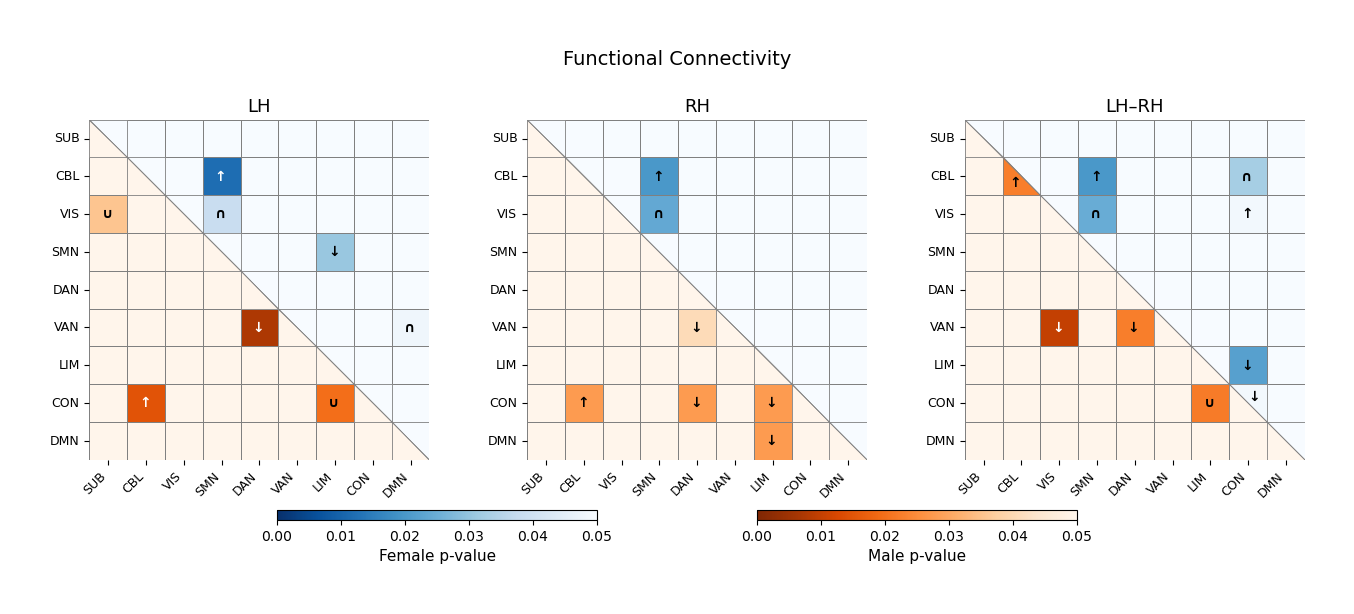

In [44]:
trend_pval_symbols(sig_fc_m, sig_fc_f, alpha=0.05, nets=None, figsize=(16,5), correction_method="fdr_bh", use_corrected_p=True, title_prefix= 'Functional Connectivity') #FC

/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/midtier/cocolab/scratch/keh4016/.conda/envs/sex_diff/lib/python3.12/site-packages/seaborn/matrix.py:207: Runt

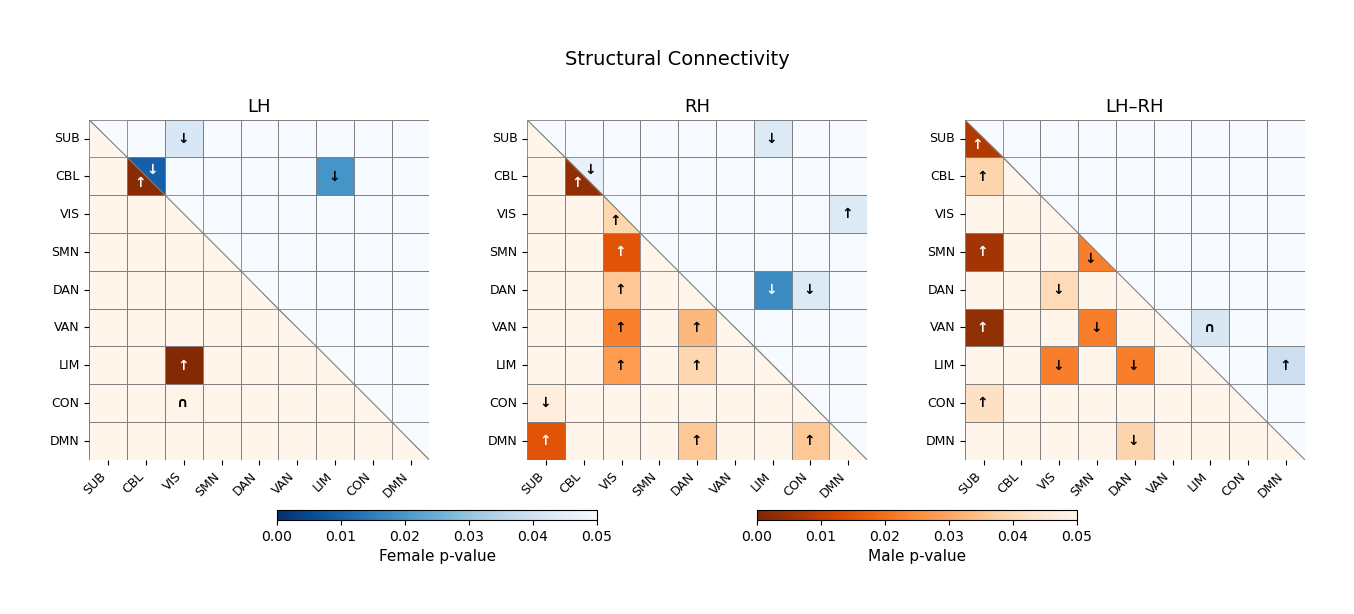

In [45]:
trend_pval_symbols(sig_sc_m, sig_sc_f, alpha=0.05, nets=None, figsize=(16,5), 
                   correction_method="fdr_bh", use_corrected_p=True, title_prefix= 'Structural Connectivity') # SC